<h1>Computer Vision and Image Processing</h1>
<h2>Fruit Inspection - Second Task</h2>
<h4>Alex Gianelli<br/>Andrea Castronovo</h4>

In this document we will develop an Image Processing routine in order to solve the Second Task of a University Computer Vision project (<a href="./fruit-inspection.pdf">file</a>).

The target images are the following:
<ul>
    <li><a href="./second task/C1_000004.png">Image 04</a></li>
    <li><a href="./second task/C1_000005.png">Image 05</a></li>
</ul>

<b>NIR</b> versions of the same images are also provided:
<ul>
    <li><a href="./second task/C0_000004.png">NIR Image 04</a></li>
    <li><a href="./second task/C0_000005.png">NIR Image 05</a></li>
</ul>
<br/>

The objectives of this task are:
<ul>
    <li><b>identify the russet</b> or at least some part of it with no false positive areas (if possible).</li>
</ul>

We advise to <b><i>Run All</i></b> the scripts before reading the document, for a better understanding of the report.
<br/><br/>
The code begins by importing all the necessary libraries/packages.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

We first define the image that we will analize and we assign the corresponding values for <i>X_SHIFT</i> and <i>Y_SHIFT</i>. This values were determined empirically and will be used later to align the NIR image to the colored image.

<b>Choose the target image <i>HERE</i></b>.

In [2]:
# Chose the image HERE (4-5)
IMG = 5

if (IMG == 4):
    X_SHIFT = -4
    Y_SHIFT = -3
if (IMG == 5):
    X_SHIFT = 2
    Y_SHIFT = 2

We import both the colored image and the NIR. In this task we will use both images to reach the result, hence we will need to clean both backgrounds separately and then align them in order to compute our result.

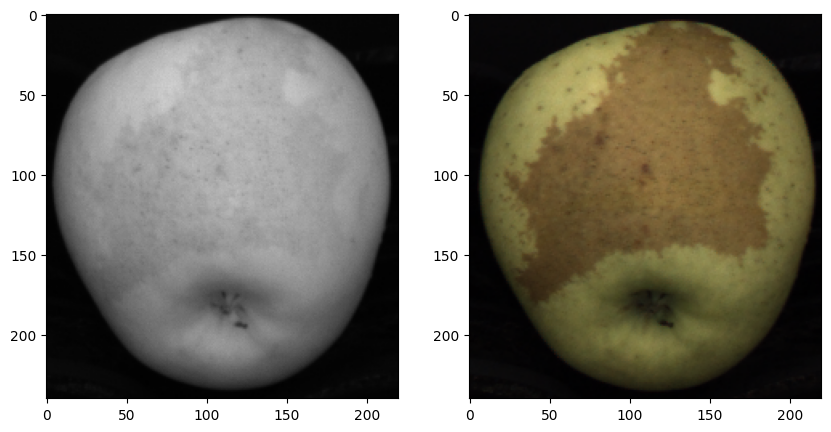

In [3]:
img = cv2.imread('second task/C0_00000' + str(IMG) + ".png", cv2.IMREAD_GRAYSCALE)
img_cc = cv2.imread('second task/C1_00000' + str(IMG) + ".png")
img_c = cv2.cvtColor(img_cc, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2, figsize = (10,10))
axarr[0].imshow(img, cmap='gray', vmin = 0, vmax = 255)
axarr[1].imshow(img_c, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()

<h3>Removing Background</h3>

As we previously did in the first task, we apply a <b>Gaussian Blur</b> filter on the image (NIR) and then a simple <b>threshold</b> on blurred version, ending up with an already clear binary mask for background removal.</br> 
Here we also show a preview of the same mask applied on the colored image. It can be noticed that some pixels are cut due to the fact that they are not aligned as well as taken by a slightly shifted perspective.

<i>The function parameters were determined empirically.</i>

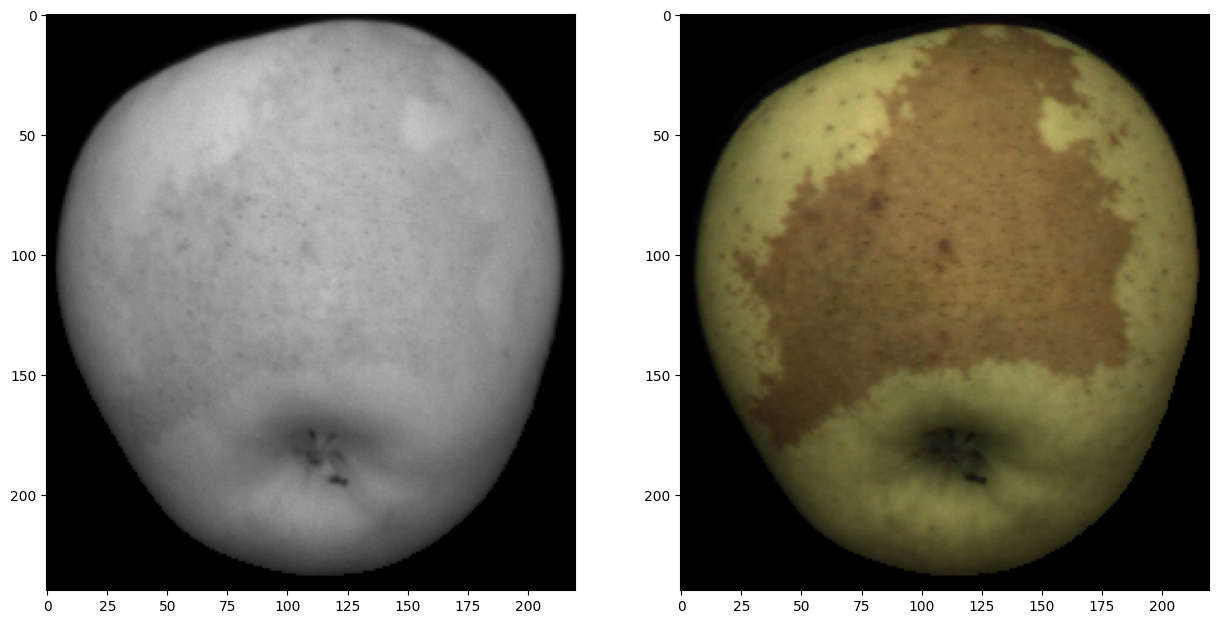

In [4]:
sigma = 2.5
k_size = int(np.ceil((3*sigma))*2 + 1)

img_gf = cv2.GaussianBlur(img, (k_size,k_size), sigma)

threshold = 30

_, mask = cv2.threshold(img_gf, threshold, 255, cv2.THRESH_BINARY_INV)

background = np.zeros_like(img)

bg_clean_nir = np.where(mask == np.array([0]), img, background)

out_fruit = bg_clean_nir & img

masked=cv2.bitwise_and(img_cc, img_cc, mask = bg_clean_nir)
temp_show=cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(bg_clean_nir, cmap = 'gray', vmin = 0, vmax = 255)
axarr[1].imshow(temp_show, vmin = 0, vmax = 255)
plt.show()

We now remove in the same way the background from the colored image. Since RGB is not the best to work with, we first convert it to <b>LAB</b> and split it in its 3 channels.

We will mainly focus on the <b>L channel</b> as it gives us most of the information we need. With the same mask we also remove the background from the <b>B channel</b>, afer a normalization, as we will be needing it later.

We also create another thing needed later which is the <i>external_edge</i> which is just a 1 thickness edge mask.

<i>The function parameters were determined empirically.</i>

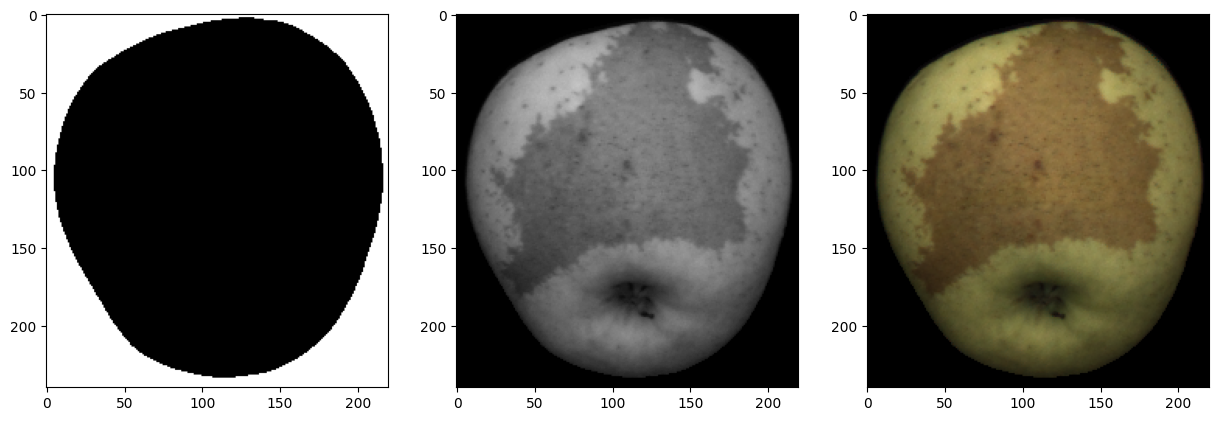

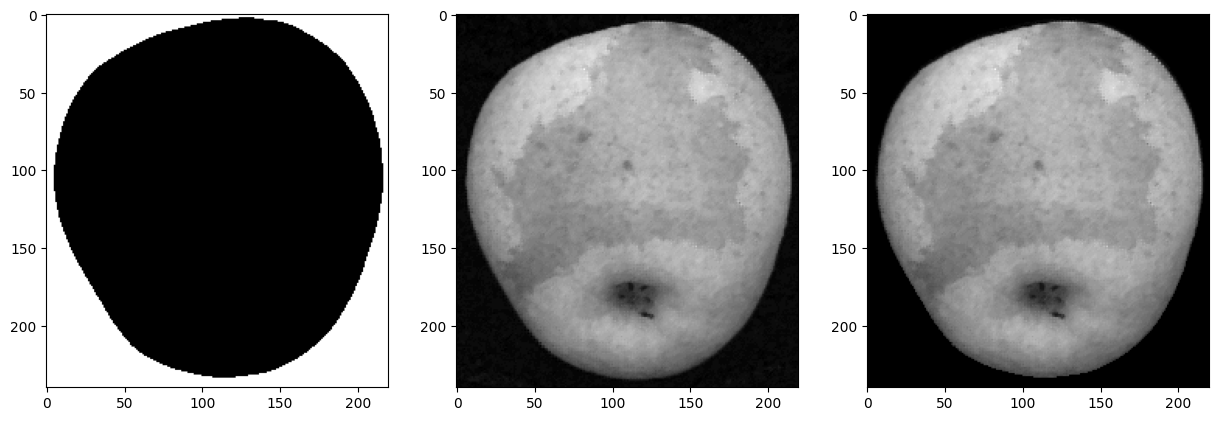

In [5]:
f_lab = cv2.cvtColor(img_c, cv2.COLOR_RGB2LAB)

l, a, b = cv2.split(f_lab)

selected_channel = l
secondary_channel = b

img_gf = cv2.GaussianBlur(selected_channel, (k_size,k_size), sigma)

threshold = 27

_, mask = cv2.threshold(img_gf, threshold, 255, cv2.THRESH_BINARY_INV)

edges = cv2.Canny(mask, 100, 200)

background = np.zeros_like(l)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_mask = np.zeros_like(mask)
external_edge = np.zeros_like(mask)

cv2.drawContours(filtered_mask, contours, -1, 255, thickness=cv2.FILLED)
cv2.drawContours(external_edge, contours, -1, 255, thickness=1)

mask_rgb = cv2.bitwise_not(filtered_mask)

bg_clean_sc = np.where(mask_rgb==np.array([0]), selected_channel, background)
bg_clean_rgb_full = cv2.bitwise_and(img_c,img_c,mask=bg_clean_sc)

b_norm = cv2.normalize(secondary_channel, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
bg_clean_rgb_b = np.where(mask_rgb==np.array([0]), b_norm, background)

f, axarr = plt.subplots(1,3, figsize = (15,15))
axarr[0].imshow(mask_rgb,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(bg_clean_sc,cmap='gray',vmin=0, vmax=255)
axarr[2].imshow(bg_clean_rgb_full,vmin=0, vmax=255)
plt.show()

f, axarr = plt.subplots(1,3, figsize = (15,15))
axarr[0].imshow(mask_rgb,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(b_norm,cmap='gray',vmin=0, vmax=255)
axarr[2].imshow(bg_clean_rgb_b,cmap='gray',vmin=0, vmax=255)
plt.show()

<h3>Image Alignment</h3>
Now that we have no background in both images, we can finally <b>align</b> them as much as we can.

We tried much more complex ways for alignment and warping, but any algorithm we tried couldn't find enough correspondencies between the two images to compute the right homography. We also tried to compute this homography on the borders binary masks but we had the same results.

We can also see on the bottom part that the NIR fruit seems bigger, probably given by a combination of both perspective and distance difference. 

Also, for some reason the cameras seem to shift in position as we needed to use much different values to align (manually) the two images.

We know that this wouldn't work on unseen images but we expect that if we were to apply this method sistemetically in an industrial setting we could try a better/consistent camera placement or maybe get some information on a large pool of images for an automatic alignment method.

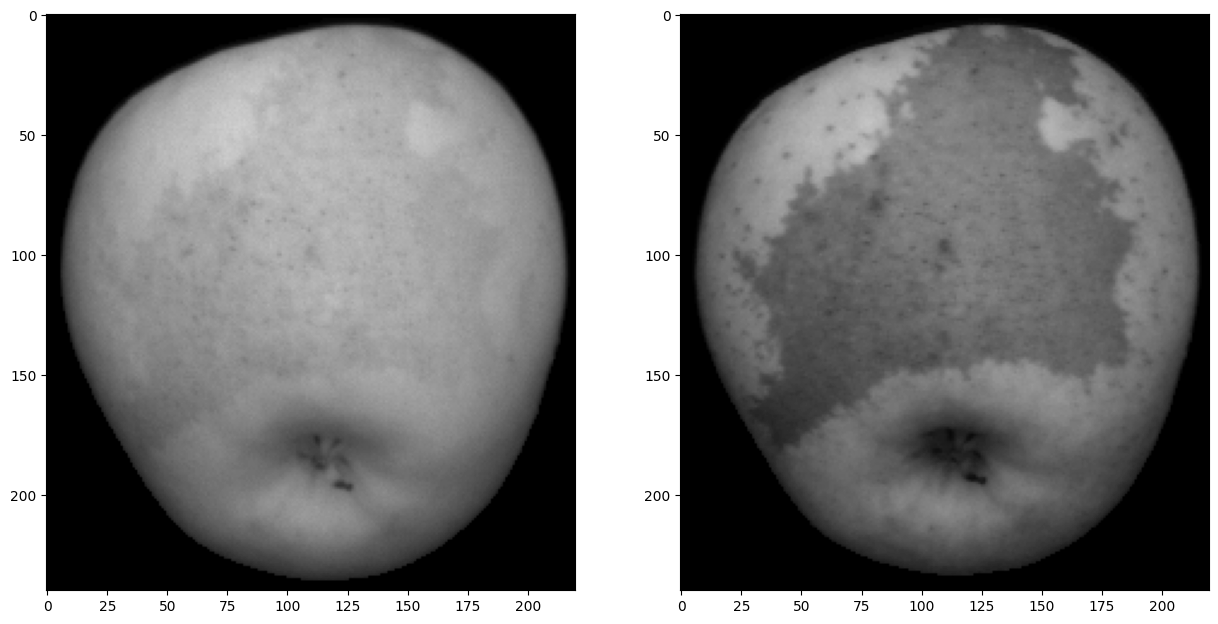

In [6]:
M = np.float32([[1, 0, X_SHIFT], [0, 1, Y_SHIFT]])

shifted_nir = cv2.warpAffine(bg_clean_nir, M, (bg_clean_nir.shape[1], bg_clean_nir.shape[0]))

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(shifted_nir,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(bg_clean_sc,cmap='gray',vmin=0, vmax=255)
plt.show()

<h3>Identify the russet</h3>

We can now focus on the identification of the russet itself. We can notice that the L channel of the LAB image shows distinctively the areas of the russet where as the NIR shows barely any change. We can use this to compute a difference between the two images.

The main problem with this approach is that in some areas the L channel shows much noise where the areas of the fruit have a different color (mainly red in image 4) from the russet. However, this areas are shown much less on the B channel that we previously mentioned would come in handy. After a normalization, we can use a <b>weighted addiction</b> to have an average (weighted) value between the two images in order to reduce this problem. (This does also make some of the russet areas a bit less visible but not significantly)

We also used a <b>median blur</b> filter to have less noise on the "weighted" image before computing the <b>difference</b>.

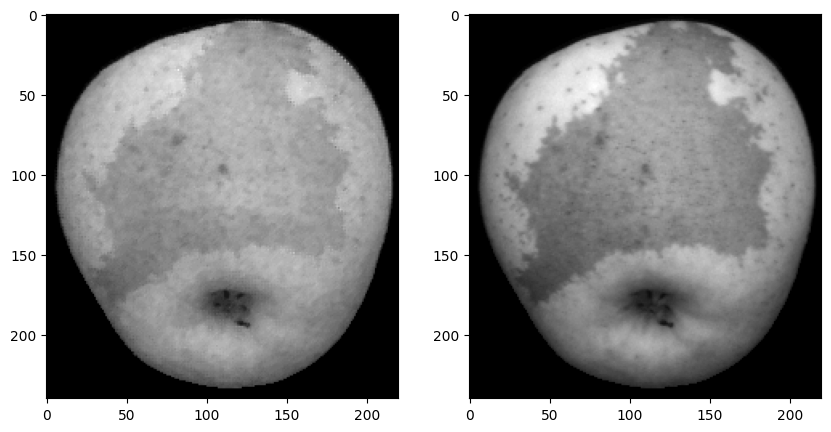

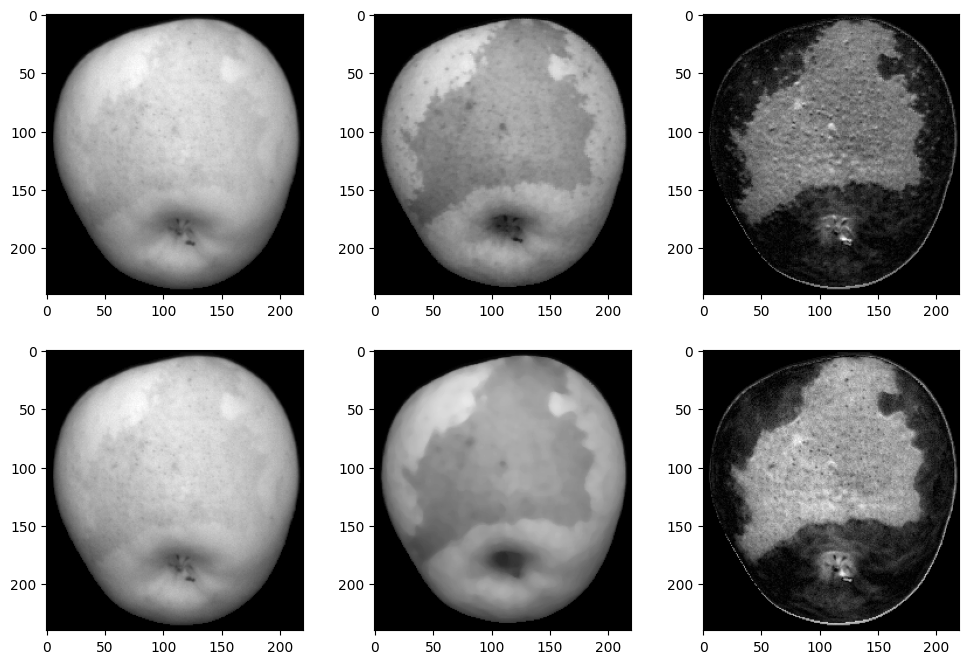

In [7]:
img_nir_norm = cv2.normalize(shifted_nir, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
img_gray_norm = cv2.normalize(bg_clean_sc, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

f, axarr = plt.subplots(1,2, figsize = (10,10))
axarr[0].imshow(bg_clean_rgb_b,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(img_gray_norm,cmap='gray',vmin=0, vmax=255)
plt.show()

weighted = cv2.addWeighted(bg_clean_rgb_b, 0.5, img_gray_norm,0.5,0)

blurm_sc = cv2.medianBlur(weighted, 7)

diff_clear = cv2.absdiff(img_nir_norm, weighted)
diff_blurm = cv2.absdiff(img_nir_norm, blurm_sc)

diff_clear = cv2.normalize(diff_clear, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
diff_blurm = cv2.normalize(diff_blurm, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

f, axarr = plt.subplots(2,3, figsize = (12,8))
axarr[0,0].imshow(img_nir_norm,cmap='gray',vmin=0, vmax=255)
axarr[0,1].imshow(weighted,cmap='gray',vmin=0, vmax=255)
axarr[0,2].imshow(diff_clear,cmap='gray',vmin=0, vmax=255)
axarr[1,0].imshow(img_nir_norm,cmap='gray',vmin=0, vmax=255)
axarr[1,1].imshow(blurm_sc,cmap='gray',vmin=0, vmax=255)
axarr[1,2].imshow(diff_blurm,cmap='gray',vmin=0, vmax=255)
plt.show()

We now <i>subtract a dilated edge</i> to our difference image and normalize again. We have now good conditions to apply a <b>Gaussian blur followed by Canny</b> and find our edges.

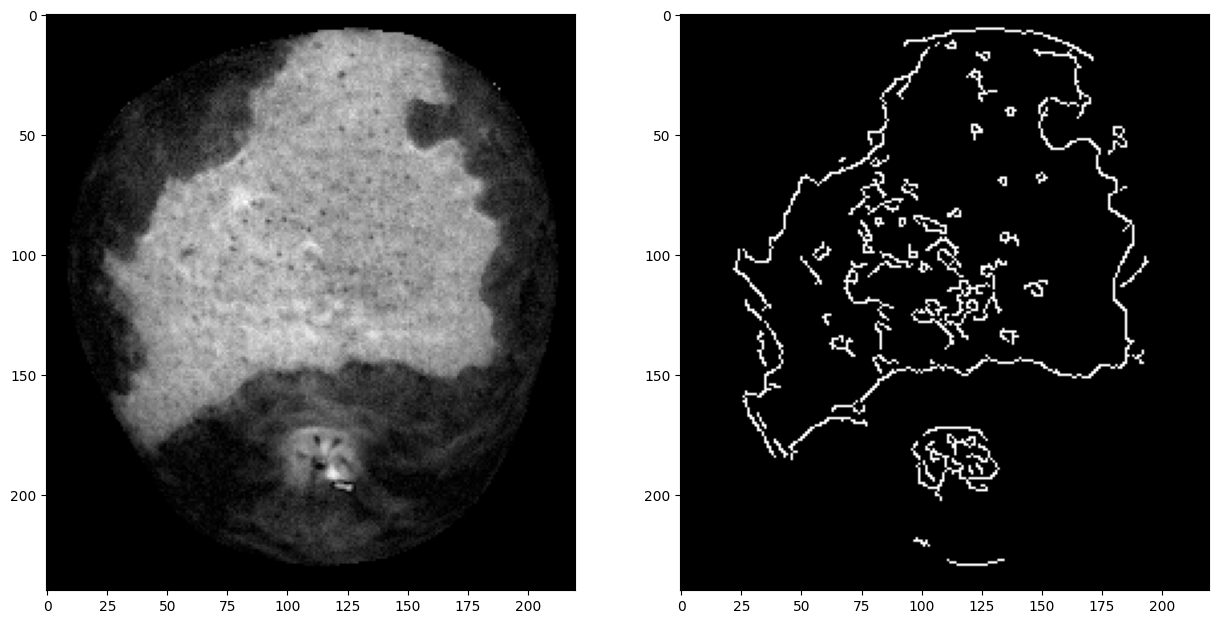

In [8]:
ellipse_3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
dilated_ext_edge = cv2.dilate(external_edge, ellipse_3, iterations = 3)

no_border = np.where(dilated_ext_edge==255, background, diff_blurm)
diff_norm = cv2.normalize(no_border, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

g_norm = cv2.GaussianBlur(diff_norm, (3,3), 1.2)

edge = cv2.Canny(g_norm, 70, 158)

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(diff_norm,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(edge,cmap='gray',vmin=0, vmax=255)
plt.show()

After a small dilate operator to make the edges a bit more consistent and a morph to close them, we can now filter the contours that we don't deem to be belonging to the russet. To do this, a few observations and assumptions have been made:
<ul>
    <li>The russet color is always <b>brownish</b> in color.</li>
    <li>We assume that the russet needs to have a <b>minimum area dimension</b> in order to be consider as such.</li>
</ul>

We have than used the following criteria in the filtering process:
<ol>
    <li>The contours with an <b>area</b> under a given thresold will not be considered.</li>
    <li>We compute the <b>mean of the difference</b> inside the contoure and threshold low difference areas.</li>
    <li>Finally we observe the <b>r and g</b> values and check if there is a minimum distance between the means. This means that we can filter the brownish areas from the greyish ones</li>
</ol>

With the contours filtered we create two masks, one filled and one with thick borders.
We then use both to compute a mask that gives us a thick border of our filled mask.

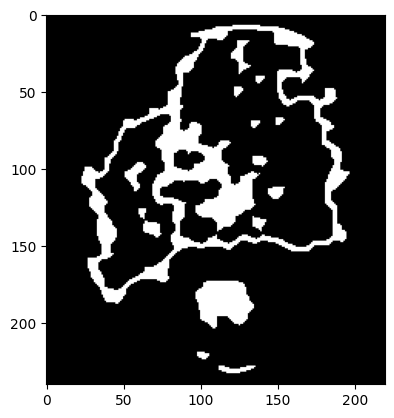

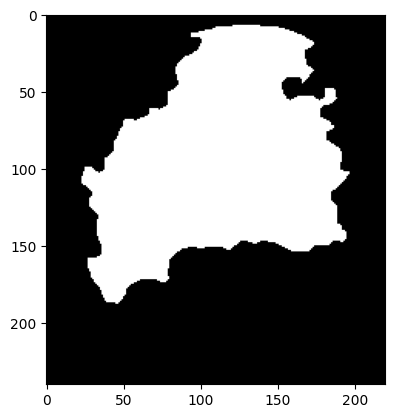

In [9]:
edge[edge<255] = 0

ellipse_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
dilated_edges = cv2.dilate(edge, ellipse_2, iterations = 2)

ellipse_6 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
edge_morph = cv2.morphologyEx(dilated_edges, cv2.MORPH_CLOSE, ellipse_6)

plt.imshow(edge_morph, cmap='gray', vmin=0, vmax=255)
plt.show()

contours, _ = cv2.findContours(edge_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

inner_contours = np.zeros_like(img)
inner_contours_edge = np.zeros_like(img)

for contour in contours:
    area = cv2.contourArea(contour)

    mask = np.zeros_like(img)
    cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)

    mean_color = cv2.mean(diff_norm, mask=mask)

    if area > 400 and mean_color[0] > 70:
        r,g,b = cv2.split(bg_clean_rgb_full)
        mean_r = cv2.mean(r, mask=mask)
        mean_g = cv2.mean(g, mask=mask)

        diff = np.abs(mean_r[0] - mean_g[0])

        if diff > 10:
            cv2.drawContours(inner_contours, [contour], -1, (255), thickness=cv2.FILLED)
            cv2.drawContours(inner_contours_edge, [contour], -1, (255), thickness=20)

plt.imshow(inner_contours, cmap='gray', vmin=0, vmax=255)
plt.show()

contour_pixels = np.where(cv2.addWeighted(inner_contours, 0.5, inner_contours_edge,0.5,0) == 255)

We can now use this last computed border to make a <b>controlled erosion</b>. Given the fact that we used some blur in the previous steps this helps us remove some areas of the border that don't have a significant distance in the unblurred difference image. 

We then use morphology to clean the mask.

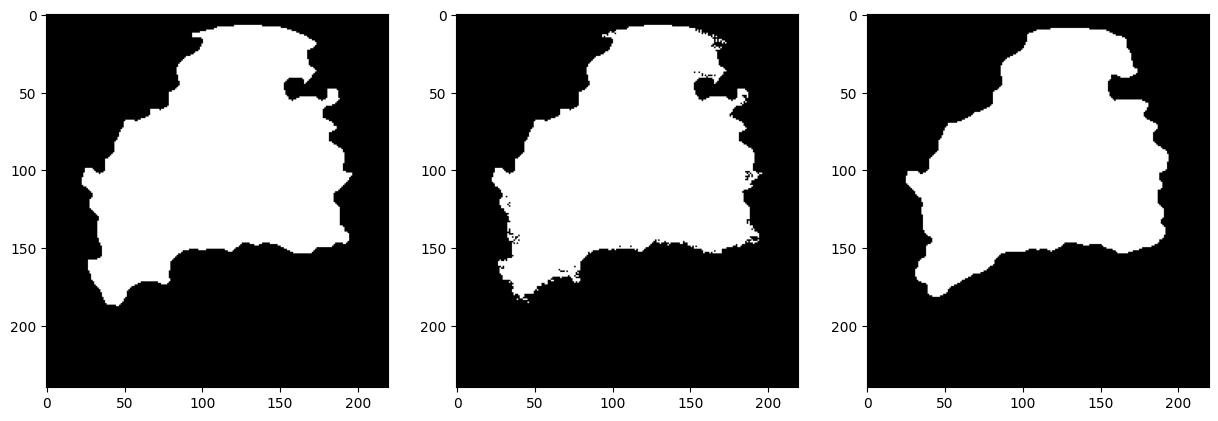

In [10]:
eroded = inner_contours.copy()
for i in range(len(contour_pixels[0])):
    y, x = contour_pixels[0][i], contour_pixels[1][i]

    diff = diff_clear[y, x]
    if diff < 25:
        eroded[y,x] = 0


ellipse_4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))

cleaned = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, ellipse_6)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, ellipse_4)

f, axarr = plt.subplots(1,3, figsize = (15,15))
axarr[0].imshow(inner_contours,cmap='gray',vmin=0, vmax=255)
axarr[1].imshow(eroded,cmap='gray',vmin=0, vmax=255)
axarr[2].imshow(cleaned,cmap='gray',vmin=0, vmax=255)
plt.show()

We are now able to mark the defects on the colored image using the mask we created. We compere the difference between the not eroded and eroded image to show that in many cases the latter comes much closer to the russet.

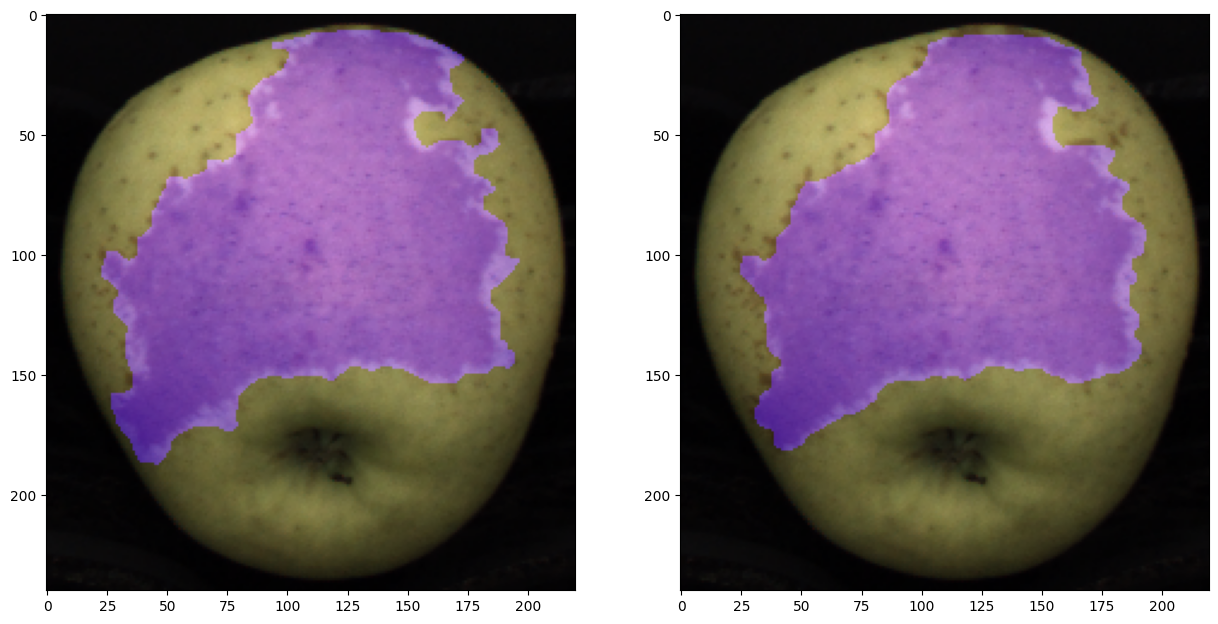

In [11]:
color_defects = np.zeros_like(img_c)

color_defects[inner_contours == 255] = [40, 0, 160]

highImg = cv2.addWeighted(img_c, 1, color_defects, 0.8, 0)

color_defects_er = np.zeros_like(img_c)

color_defects_er[cleaned == 255] = [40, 0, 160]

highImg_er = cv2.addWeighted(img_c, 1, color_defects_er, 0.8, 0)

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(highImg)
axarr[1].imshow(highImg_er)
plt.show()